### Работа с изображениями. Сверточные нейронные сети.

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev


#### План занятия:
1. Введение в компьютерное зрение и сверточные нейронные сети
2. Классификация изображений с помощью сверточных нейронных сетей
3. Использование предобученной модели в качестве backbone.

### 1. Введение в компьютерное зрение и сверточные нейронные сети
Введем формально понятие изображения:

__Изображения__ – тип данных, где каждый объект состоит из упорядоченного по двум осям набора пикселей. Каждое изображение обладает пространственной структурой, информация кроется в том, как пиксели упорядочены. Перестановка пикселей приводит к потере информации.

Для задач компьютерного зрения себя отлично зарекомендовали сверточные сети, в основе которых стоит операция свертки:
<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" width="400">
*Image source: https://github.com/vdumoulin/conv_arithmetic*

Сверточные нейронные сети учитывают пространственную структуру изображений, что позволяет им автоматически находить информативные признаковые описания данных.

__Go to slides__

Рассмотренные ранее известные архитектуры часто используются в роли __backbone__. Эта часть модели, ответственная за извлечение признаков, по факту выступает в роли энкодера (т.е. строит информативное признаковое описание данных, не обязательно в виде вектора). Как правило, backbone-сеть уже предобучена на крупной выборке (например, на ImageNet). Иногда она дообучается (т.е. происходит fine-tuning) под конкретную задачу.

### 2. Классификация изображений с помощью сверточных нейронных сетей
Построим простую сверточную нейронную сеть. Будем решать задачу классификации на примере классического набора данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Он также доступен в библиотеке `torchvision`.

In [11]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"figure.figsize": (12, 8), "font.size": 14})

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

data_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=True, num_workers=2)
data_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=238, shuffle=False, num_workers=2)

class_labels = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [13]:
example_batch, example_labels = [x[:5] for x in next(iter(train_loader))]

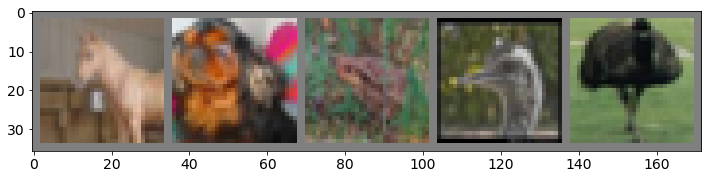

	  horse		dog		frog		bird		bird


In [14]:
def show_batch(batch):
    batch = batch / 2 + 0.5
    image_batch = np.transpose(batch.numpy(), (1, 2, 0))
    plt.imshow(image_batch)
    plt.show()


show_batch(torchvision.utils.make_grid(example_batch))
print("\t  " + "\t\t".join([class_labels[i] for i in example_labels]))

Разрешение изображений достаточно невысокое, но многие объекты все еще различимы человеком (экспертом).

Построим простую нейронную сеть:

In [31]:
def create_small_net():
    net = nn.Sequential(
        *[
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        ]
    )
    return net

In [32]:
model = create_small_net()

model(example_batch[:1]).shape

torch.Size([1, 10])

Для обучения и оценки качества модели реализуем простые функции:

In [34]:
def train_one_step(model, optimizer, criterion, inputs, labels):
    optimizer.zero_grad()
    out = model(inputs)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

In [36]:
def evaluate_model(model, dataloader, device, caption=""):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.cpu().data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("Accuracy of the network on the 10000 {} images: {:.4f}".format(caption, correct / total))

In [37]:
model = create_small_net()

In [38]:
summary(model, example_batch.shape[1:], device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 128]          51,328
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 63,106
Trainable params: 63,106
Non-trainable params: 0
---------------------------------

В сети около 60 тысяч параметров. По современным меркам, это совсем немного. Например, в BERT Large – 340 миллионов параметров, в GPT-2 – 1.5 миллиарда параметров.

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
device

device(type='cuda')

Обучим модель:

In [42]:
NUM_EPOCHS = 15

In [43]:
model_gpu = create_small_net().to(device)
optimizer_gpu = optim.Adam(model_gpu.parameters())

In [44]:
loss_history = []
model.train()
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_loss = train_one_step(model_gpu, optimizer_gpu, criterion, inputs, labels)
        epoch_loss += batch_loss / len(inputs)
    print("Epoch: {}, loss = {:.4f}".format(epoch + 1, epoch_loss))
    loss_history.append(epoch_loss)

Epoch: 1, loss = 5.2053
Epoch: 2, loss = 4.3511
Epoch: 3, loss = 4.0585
Epoch: 4, loss = 3.8253
Epoch: 5, loss = 3.6442
Epoch: 6, loss = 3.4959
Epoch: 7, loss = 3.3544
Epoch: 8, loss = 3.2346
Epoch: 9, loss = 3.1276
Epoch: 10, loss = 3.0350
Epoch: 11, loss = 2.9385
Epoch: 12, loss = 2.8567
Epoch: 13, loss = 2.7767
Epoch: 14, loss = 2.6867
Epoch: 15, loss = 2.6180


Оценим качество классификации на тестовой выборке:

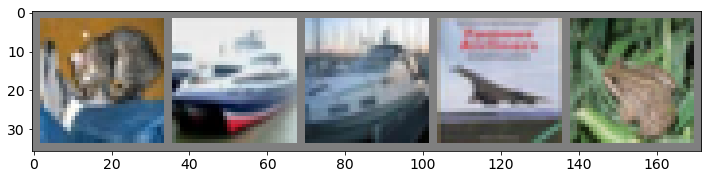

	   cat		ship		ship		plane		frog


In [47]:
test_batch, test_labels = [x[:5] for x in next(iter(test_loader))]

show_batch(torchvision.utils.make_grid(test_batch))
print("\t   " + "\t\t".join([class_labels[i] for i in test_labels]))

In [48]:
evaluate_model(model_gpu, test_loader, device, "test")

Accuracy of the network on the 10000 test images: 0.6309


### 3. Использование предобученной модели в качестве backbone.

Теперь воспользуемся моделью из семейства [ResNet](https://arxiv.org/abs/1512.03385), предобученной на датасете [ImageNet](http://image-net.org). Будем использовать ее в качестве backbone.

In [49]:
model_resnet18 = torchvision.models.resnet18(pretrained=True)

In [50]:
summary(model_resnet18, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [54]:
list(model_resnet18.children())[:-5]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [55]:
model_resnet18 = torchvision.models.resnet18(pretrained=True)
n_features = 64
n_classes = len(class_labels)

used_modules = list(model_resnet18.children())[:-5] + [
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(n_features, n_classes),
]
resnet_trimmed = nn.Sequential(*used_modules)

Для начала дообучим только последний слой сети:

In [56]:
for p in resnet_trimmed.parameters():
    p.requires_grad = False

resnet_trimmed[-1].requires_grad_(True)
resnet_trimmed = resnet_trimmed.to(device)

На всякий случай проверим:

In [57]:
for p in resnet_trimmed.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [58]:
summary(resnet_trimmed, (3, 32, 32), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [59]:
optimizer_resnet_trimmed = optim.Adam(resnet_trimmed.parameters(), lr=0.001)

In [60]:
loss_history = []
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_loss = train_one_step(
            resnet_trimmed, optimizer_resnet_trimmed, criterion, inputs, labels
        )
        epoch_loss += batch_loss / len(inputs)
    print("Epoch: {}, loss = {:.4f}".format(epoch + 1, epoch_loss))
    loss_history.append(epoch_loss)

Epoch: 1, loss = 6.5755
Epoch: 2, loss = 5.8973
Epoch: 3, loss = 5.5149
Epoch: 4, loss = 5.2747
Epoch: 5, loss = 5.1071
Epoch: 6, loss = 4.9811
Epoch: 7, loss = 4.8843
Epoch: 8, loss = 4.8061
Epoch: 9, loss = 4.7434
Epoch: 10, loss = 4.6884
Epoch: 11, loss = 4.6438
Epoch: 12, loss = 4.6044
Epoch: 13, loss = 4.5676
Epoch: 14, loss = 4.5366
Epoch: 15, loss = 4.5082


In [61]:
evaluate_model(resnet_trimmed, test_loader, device, "test")

Accuracy of the network on the 10000 test images: 0.4998


Стоит учесть, что ResNet обучался на более сложных данных (разрешение ImageNet 224:224). Возможно, начиная с некоторого момента, стоит дообучать не только последний слой, но и остальные (обучение последнего слоя необходимо, чтобы модель давала не совсем бессмысленные предсказания).

Для этого заново инициализируем ResNet:

In [62]:
model_resnet18 = torchvision.models.resnet18(pretrained=True)
n_features = 64
n_classes = len(class_labels)

used_modules = list(model_resnet18.children())[:-5] + [
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(n_features, n_classes),
]
resnet_trimmed = nn.Sequential(*used_modules)
for p in resnet_trimmed.parameters():
    p.requires_grad = False

resnet_trimmed[-1].requires_grad_(True)
resnet_trimmed = resnet_trimmed.to(device)
optimizer_resnet_trimmed = optim.Adam(resnet_trimmed.parameters(), lr=0.001)

In [63]:
loss_history = []
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_loss = train_one_step(
            resnet_trimmed, optimizer_resnet_trimmed, criterion, inputs, labels
        )
        epoch_loss += batch_loss / len(inputs)
    print("Epoch: {}, loss = {:.4f}".format(epoch + 1, epoch_loss))
    loss_history.append(epoch_loss)

    if epoch == 2:
        for p in resnet_trimmed.parameters():
            p.requires_grad = True

Epoch: 1, loss = 6.5618
Epoch: 2, loss = 5.8911
Epoch: 3, loss = 5.5143
Epoch: 4, loss = 3.3083
Epoch: 5, loss = 2.3651
Epoch: 6, loss = 2.0012
Epoch: 7, loss = 1.7833
Epoch: 8, loss = 1.6139
Epoch: 9, loss = 1.4802
Epoch: 10, loss = 1.3642
Epoch: 11, loss = 1.2504
Epoch: 12, loss = 1.1716
Epoch: 13, loss = 1.0836
Epoch: 14, loss = 1.0069
Epoch: 15, loss = 0.9304


In [64]:
evaluate_model(resnet_trimmed, train_loader, device, "train")

Accuracy of the network on the 10000 train images: 0.8808


In [65]:
evaluate_model(resnet_trimmed, test_loader, device, "test")

Accuracy of the network on the 10000 test images: 0.7820


В целом качество классификации выросло.

Рассмотрим accuracy по каждому классу отдельно:

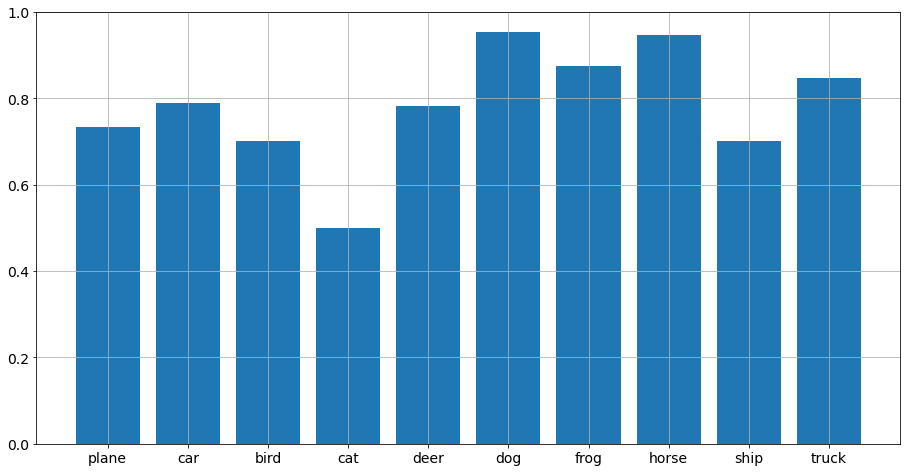

In [66]:
class_correct = np.zeros(10)
class_total = np.zeros(10)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = resnet_trimmed(images.to(device))
        _, predicted = torch.max(outputs.cpu(), 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

fig = plt.figure(figsize=(12, 8))

ax = fig.add_axes([0, 0, 1, 0.75])  # main axes
_bar = ax.bar(np.arange(n_classes), class_correct / class_total)
ax.set_xticks(list(np.arange(n_classes)))
_ = ax.set_xticklabels(class_labels)
plt.grid()

В качестве эксперимента обучим ResNet c нуля:

In [67]:
model_resnet18_raw = torchvision.models.resnet18(pretrained=False)

used_modules = list(model_resnet18_raw.children())[:-5] + [
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(n_features, n_classes),
]
resnet_trimmed_raw = nn.Sequential(*used_modules)
resnet_trimmed_raw = resnet_trimmed.to(device)

optimizer_resnet_trimmed_raw = optim.Adam(resnet_trimmed_raw.parameters(), lr=0.001)

loss_history = []
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_loss = train_one_step(
            resnet_trimmed_raw, optimizer_resnet_trimmed_raw, criterion, inputs, labels
        )
        epoch_loss += batch_loss / len(inputs)
    print("Epoch: {}, loss = {:.4f}".format(epoch + 1, epoch_loss))
    loss_history.append(epoch_loss)


evaluate_model(resnet_trimmed_raw, train_loader, device, "train")
evaluate_model(resnet_trimmed_raw, test_loader, device, "test")

Epoch: 1, loss = 1.0179
Epoch: 2, loss = 0.9150
Epoch: 3, loss = 0.8621
Epoch: 4, loss = 0.8436
Epoch: 5, loss = 0.8114
Epoch: 6, loss = 0.7804
Epoch: 7, loss = 0.7107
Epoch: 8, loss = 0.7250
Epoch: 9, loss = 0.6688
Epoch: 10, loss = 0.6281
Epoch: 11, loss = 0.6582
Epoch: 12, loss = 0.5746
Epoch: 13, loss = 0.5286
Epoch: 14, loss = 0.5204
Epoch: 15, loss = 0.5078
Accuracy of the network on the 10000 train images: 0.9626
Accuracy of the network on the 10000 test images: 0.8006


### Выводы
* Сверточные подходят для анализа изображений и в целом данных со сложной структурой (например, временных рядов и даже текстов) благодаря их способности учитывать локальную структуру в данных.

* Использование предобученных моделей позволяет получать качественные результаты в задачах компьютерного зрения. Предобученная модель уже "обладает знанием" о характерных признаках изображений и об их общей структуре, как правило, выученных при работе с большими наборами данных.

* Стоит помнить, что предобученная модель была обучена под конретную задачу. Если модель обучалась на медицинских данных, она вряд ли сильно поможет в задача распознавания рукописного текста.

* Для многих задач интерес представляют лишь несколько первых слоев нейронной сети, способных извлекать низкоуровневые информативные признаки. Например, модель, обученная на задаче анализа медицинских изображений (рентген) может быть полезна при работе с данными о структуре металла. 

* Стоит помнить, что сами данные должны быть преобразованы к подходящему виду (размер, цветовое пространство, яркость и пр.)

* Использование нейронных сетей подходящей структуры позволяет добиваться знамых результатов во многих областях. Если архитектура сети учитываев структуру и свойсва используемых данных, то шансы на успешное решение задачи значительно выше.